# Description:
This Jupyter notebook contains all python functions developed for this work in order
to allow for easy importing. The common functions are organised per notebook in which they were first used.

# Import modules:

In [1]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot
import os
import scipy.integrate
from scipy.optimize import curve_fit
#%matplotlib widget

# Define Constants:

In [1]:
DataPath="/mnt/c/Users/Jethro/Desktop/Master thesis/RNO_DATA_DIR"

## Firmware changes run number

Source: following message from slack group chat  rno-g ops <br>
avinngaq is on station 22, nanoq is on station 11 and amaroq is on station 21

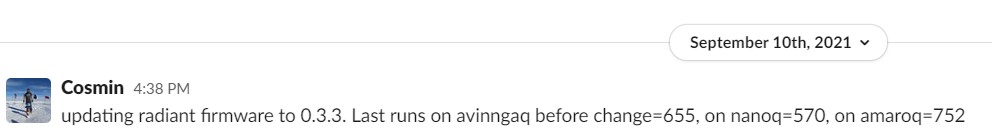

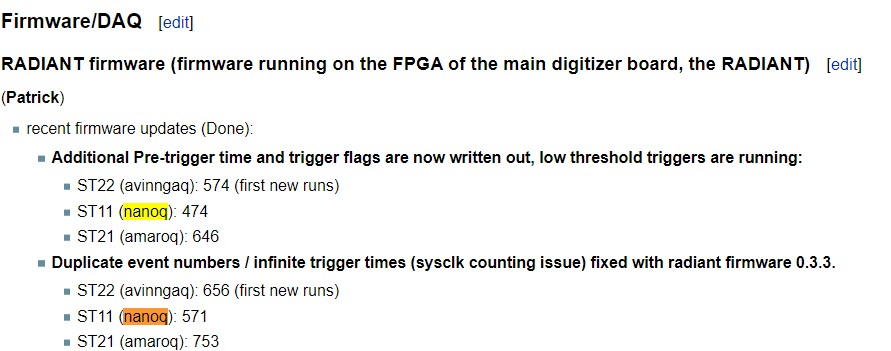

Define a dictionary for easy reference of when each station started using the new firmware:

In [2]:
FirmwareSwitch = { #Runs for each station that start using the new firmware
  "St11": 571,
  "St21": 753,
  "St22": 656
}

In [3]:
FirmwareSwitch["St21"]

753

In [1]:
def TimeTrace(StNr,ChNr,Run,EvNr,Amplitude="V"):
    
    path=Path(StNr,Run)
    if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
        
        CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
        RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
        EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
        TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
    
    else:
        return
    
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
        
    
    EvIndex=np.where(EventNrs==EvNr)[0][0]
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
    
    plt.figure(figsize=(20,5))
    
    if Amplitude=="V":
        plt.plot(SamplingTimes*(10**9),ADCtoVoltage(RadiantData[EvIndex][ChNr]),'-', label="Channel " + str(ChNr))
        plt.ylabel("Amplitude (V)",fontsize=40)#20)
    elif Amplitude=="mV":
        plt.plot(SamplingTimes*(10**9),1000*ADCtoVoltage(RadiantData[EvIndex][ChNr]),'-', label="Channel " + str(ChNr))
        plt.ylabel("Amplitude (mV)",fontsize=40)#20)
    elif Amplitude=="ADC":
        plt.plot(SamplingTimes*(10**9),RadiantData[EvIndex][ChNr],'-', label="Channel " + str(ChNr))
        plt.ylabel("Amplitude (ADC)",fontsize=40)#20)        
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("Time trace of St" + str(StNr) + ", Ch" + str(ChNr) + ", Run " + str(Run) + ", Evt " + str(EvNr),fontsize=50)#25)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(SamplingTimes*(10**9)))
    plt.xlabel("Time (ns)",fontsize=40)#20)

    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()

In [1]:
def TimeTraceFFT(StNr,ChNr,Run,EvNr,Amplitude="V"):
    
    path=Path(StNr,Run)
    if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
        
        CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
        RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
        EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
        TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
    
    else:
        return
    
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
        
    EvIndex=np.where(EventNrs==EvNr)[0][0]
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
    freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
    freq=np.fft.fftshift(freq)
    
    plt.figure(figsize=(20,5))
    
    if Amplitude=="V":
        FFT=scfft.fft(ADCtoVoltage(RadiantData[EvIndex][ChNr]))
        FFT=np.fft.fftshift(FFT)
        plt.plot((freq*(10**-6))[int(len(freq)/2)+1:len(freq)],(2/len(SamplingTimes))*np.abs(FFT)[int(len(FFT)/2)+1:len(FFT)],'-', label="Channel " + str(ChNr))
        plt.ylabel("Amplitude (V)",fontsize=40)#20)
    elif Amplitude=="mV":
        FFT=scfft.fft(1000*ADCtoVoltage(RadiantData[EvIndex][ChNr]))
        FFT=np.fft.fftshift(FFT)
        plt.plot((freq*(10**-6))[int(len(freq)/2)+1:len(freq)],(2/len(SamplingTimes))*np.abs(FFT)[int(len(FFT)/2)+1:len(FFT)],'-', label="Channel " + str(ChNr))
        plt.ylabel("Amplitude (mV)",fontsize=40)#20)
    elif Amplitude=="ADC":
        FFT=scfft.fft(RadiantData[EvIndex][ChNr])
        FFT=np.fft.fftshift(FFT)
        plt.plot((freq*(10**-6))[int(len(freq)/2)+1:len(freq)],(2/len(SamplingTimes))*np.abs(FFT)[int(len(FFT)/2)+1:len(FFT)],'-', label="Channel " + str(ChNr))
        plt.ylabel("Amplitude (ADC)",fontsize=40)#20)  
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("FFT of Time trace of St" + str(StNr) + ", Ch" + str(ChNr) + ", Run " + str(Run) + ", Evt " + str(EvNr),fontsize=50)#25)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(freq*(10**-6)))
    plt.xlim(0,200)
    plt.xlabel("Frequency (MHz)",fontsize=40)#20)

    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()

# ChannelAverages

In [4]:
def ChannelAverage(ChannelNr,RadiantData):
    """Computes average voltage of a given channel for all its samples over all events"""
    TempSum=0
    for i in range(0,RadiantData.shape[0]):
        TempSum+= RadiantData[i][ChannelNr].mean()
    return TempSum/RadiantData.shape[0]

In [1]:
def TimeTraceRawData(ChNr,EvNr,RadiantData,EventNrs):
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
    EvIndex=np.where(EventNrs==EvNr)[0][0]
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
    
    plt.figure(figsize=(20,5))
    plt.plot(SamplingTimes*(10**9),RadiantData[EvIndex][ChNr],'-', label="Channel " + str(ChNr))
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("Time trace of channel " + str(ChNr) + " for event " + str(EvNr),fontsize=60)#25)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(SamplingTimes*(10**9)))
    plt.xlabel("Time (ns)",fontsize=50)#20)
    plt.ylabel("Amplitude",fontsize=50)#20)
    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()

In [6]:
def ChannelAvgs(ChNr,RadiantData):
    """Computes average voltage of a given channel for all its samples over each event seperately"""
    Result=np.array([])
    for i in range(0,RadiantData.shape[0]): #for every event i
        Result=np.append(Result,RadiantData[i][ChNr].mean()) 
    return Result 

In [7]:
def PlotChAvgs(ChNr,RadiantData,EventNrs):
    """Plots average voltage of a given channel for all its samples over each event seperately"""
    plt.figure(figsize=(20,5)) #visualization
    plt.plot(EventNrs,ChannelAvgs(ChNr,RadiantData),'-', label="Channel" + str(ChNr))
    plt.title("Averages of channel " + str(ChNr) + " for each event seperately")
    plt.xlabel("Event number")
    plt.ylabel("Average voltage (mV)")
    #plt.xlim(0,np.max(freq))
    #plt.legend()
    plt.show()
    return

def PedPlot(ChNr,PedestalData):
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(PedestalData[0][0])*TimeStep,TimeStep)
    
    plt.figure(figsize=(20,5))
    plt.plot(PedestalData[0][ChNr],'-', label="Channel " + str(ChNr)) #SamplingTimes*(10**9),
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("Pedestal values for channel " + str(ChNr),fontsize=20)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(SamplingTimes*(10**9)))
    #plt.xlabel("Time (ns)")
    plt.ylabel("Pedestal",fontsize=20)
    plt.xlabel("Time (ns)",fontsize=20)
    #plt.legend()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [4]:
def PedPlot(StNr,ChNr,Run):
    CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
    #RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
    #EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
    PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
    
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(PedestalData[0][0])*TimeStep,TimeStep)
    

    
    plt.figure(figsize=(20,5))
    plt.plot(PedestalData[0][ChNr],'-', label="Channel " + str(ChNr)) #SamplingTimes*(10**9),
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("Pedestal values for StNr " + str(StNr) + ", ChNr " + str(ChNr) + ", Run " + str(Run),fontsize=20)
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(SamplingTimes*(10**9)))
    #plt.xlabel("Time (ns)")
    plt.ylabel("Pedestal",fontsize=20)
    plt.xlabel("Time (ns)",fontsize=20)
    #plt.legend()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# CompareAvgEnvironment

In [9]:
def TemperatureData(Nr):
    '''Returns Temperature data of the place with number Nr in the cvs file.'''
    with open('Temperatures-data-as-seriestocolumns-2021-11-21 15_20_12.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        Temp=np.array([])
        Time=np.array([])
        for row in csv_reader:
            if line_count == 0:
                Name=row[Nr+1]
                line_count += 1
                #print("length of row is " + str(len(row)))
            elif len(row)==0:
                break
            else:
                #print(row)
                if row[Nr+1]!="":
                    #time=row[0]
                    time=dt.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S')
                    DataCount=0
                    data=float(row[Nr+1])
                    Time=np.append(Time,time)
                    Temp=np.append(Temp,data)
                    #for data in row[1:]:
                    #    if data!='':
                    #        1+1
                    #        Time=np.append(Time,time)
                    #        Temp=np.append(Temp,data)
                    
                #print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
                #print(row)
                line_count += 1
            if line_count%50000==0:
                print("progress of " + Name + " " + str(Nr) + "/" + str(len(row)-1) +" : " + str(np.round(100*line_count/477430,2)) + '%', end="\r")
        #print(f'Processed {line_count} lines.')
        #print(Data)
        return Name, Time, Temp

# WindowCheck

In [10]:
def PedestalPlot(ChNr,PedestalData):
    plt.figure(figsize=(20,5))
    plt.plot(PedestalData[0][ChNr],'-',color='b')
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("Pedestal values for channel " + str(ChNr))
    #plt.ylim(-50,50)
    #plt.xlim(0,np.max(SamplingTimes*(10**9)))
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.show()

In [11]:
def WindowValues(EvNr,ChNr,WdNr,RadiantData,EventNrs):
    """Returns all waveform sample values for the WdNr'th window of event EvNr for channel ChNr."""
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
    EvIdx=np.where(EventNrs==EvNr)[0][0]
    return RadiantData[EvIdx][ChNr][WdNr*128:(WdNr+1)*128]

In [12]:
def WindowAvgPlot(EvNr,RadiantData,EventNrs):
    """Plots all window averages of all channels for a given event number without taking into account the rolling of the data."""
    Windows=np.arange(16)
    EvIdx=np.where(EventNrs==EvNr)[0][0]
    ## Define figure
    fig, axs = plt.subplots(12,2,figsize=(20,25))
    fig.suptitle("Window averages for event " + str(EvNr), x=0.5, y=0.9, fontsize=35)

    for ChNr in range(24):
        
        if ChNr%2==0:
            Column=0
        else:
            Column=1
        
        ##Compute mean value of each window and add it to an array
        MeanVal=np.array([])
        for i in Windows: 
            MeanVal=np.append(MeanVal,np.mean(WindowValues(EvNr,ChNr,i,RadiantData,EventNrs))) 
        
        row=int((ChNr-ChNr%2)/2)
        axs[row,Column].plot(Windows,MeanVal,'.', label="Channel " + str(ChNr) ) 
        axs[row,Column].plot(Windows,np.zeros(len(Windows)),'--', color="k", alpha=0.5 ) 
        axs[row,Column].legend()
        
    ##Fix labels
    for ax in axs.flat: 
        ax.set(xlabel='Window', ylabel='Avg window voltage')
    
    plt.show()
    return

In [13]:
def OldUnroll(a,b):
    """Returns a list of the physical window numbers along which data was written chronoligically given the two starting windows according to the old firmware."""
    if a<15:
        return list(range(a,8)) + list(range(0,a)) + list(range(b,16)) + list(range(8,b))
    else:    
        return list(range(a,24)) + list(range(16,a)) + list(range(b,32)) + list(range(24,b))

In [14]:
def NewUnroll(a,b):
    """Returns a list of the physical window numbers along which data was written chronoligically given the two starting windows according to the new firmware."""
    if a<15:
        return list(range(a,16)) + list(range(0,a))
    else:    
        return list(range(a,32)) + list(range(16,a))

In [15]:
def Unroll(a,b,StNr,RunNr):
    NewFirmwareNr=FirmwareSwitch["St"+str(StNr)]
    if RunNr>=NewFirmwareNr:
        return NewUnroll(a,b)
    else:
        return OldUnroll(a,b)

In [16]:
def PhysicalWindowAvgPlot(EvNr,RadiantData,EventNrs,StartWindow,StNr,RunNr,Zeropoint=0):
    """Plots all window averages of all channels for a given event number, taking into account the rolling of the data."""
    Windows=np.arange(16)
    EvIdx=np.where(EventNrs==EvNr)[0][0]
    ymin=np.mean(WindowValues(EvNr,0,0,RadiantData,EventNrs))
    ymax=np.mean(WindowValues(EvNr,0,0,RadiantData,EventNrs))
    
    ##Define figure
    fig, axs = plt.subplots(12,2,figsize=(20,25))
    fig.suptitle("Window averages for event " + str(EvNr), x=0.5, y=0.9, fontsize=35)
    
    for ChNr in range(24): 
        if ChNr%2==0:
            Column=0
        else:
            Column=1
        
        ##Unrolling process
        WinStart=StartWindow[EvIdx][ChNr]
        #WinStart=np.array([WinStart[0]%16,WinStart[1]%16]) ##Don't know how to deal with this => %16
        PhysWin=Unroll(WinStart[0],WinStart[1],StNr,RunNr)
        
        ##Compute mean value of each physical window and add it to an array
        MeanVal=np.array([])
        for i in Windows:
            MeanVal=np.append(MeanVal,np.mean(WindowValues(EvNr,ChNr,i,RadiantData,EventNrs)))
            if MeanVal[-1]>ymax:
                ymax=MeanVal[-1]
            if MeanVal[-1]<ymin:
                ymin=MeanVal[-1]
        
        row=int((ChNr-ChNr%2)/2)
        axs[row,Column].plot(PhysWin,MeanVal,'.', label="Channel " + str(ChNr) ) 
        axs[row,Column].plot(range(32),np.ones(32)*Zeropoint,'--', color="k", alpha=0.5 )
        axs[row,Column].legend()
        axs[row,Column].set_xlim([0, 32])

    plt.xlabel("Window")
    plt.ylabel("ADC counts")

    ##Fix axis labels
    for ax in axs.flat:
        ax.set(xlabel='Physical Window', ylabel='Avg ADC count')
        ax.set_ylim([ymin, ymax])
    plt.show()
    return

In [17]:
def WaveformWithPedestals(RadiantData,StartWindow,PedestalData,EventNrs,StNr,RunNr):
    """Returns the pre pedestal subtracted dataset given the pedestal subtracted dataset, startwindows and pedestal data."""
    ##Copy the datastructure
    Result=RadiantData*0
    
    for EvIdx in range(RadiantData.shape[0]): #For every event in the Data
        for ChNr in range(RadiantData.shape[1]): #For every Channel in the Data
            
            ##Obtain the physical windows
            PhysWindows=Unroll(StartWindow[EvIdx][ChNr][0],StartWindow[EvIdx][ChNr][1],StNr,RunNr)
            for WdIdx in range(16): #for every window in waveform
                WaveWindow=WindowValues(EventNrs[EvIdx],ChNr,WdIdx,RadiantData,EventNrs)
                PhysWnIdx=PhysWindows[WdIdx] #Physical window corresponding to the current window
                
                ##Obtain the pedestal window
                PedestalWindow=PedestalData[0][ChNr][PhysWnIdx*128:(PhysWnIdx+1)*128]
                
                ##Add original wavefor window and pedestal window sample-wise
                Result[EvIdx][ChNr][WdIdx*128:(WdIdx+1)*128]=WaveWindow+PedestalWindow
                
    return Result

# ADCCountDistrInspect

In [18]:
def ADCDistChRun(ChNr,RadiantData,StartWindow,EventNrs,StNr,RunNr,NBins=20):
    """Shows the distribution in ADC counts for a given channel number for all physical windows of the RadiantData from one run."""
    Windows=np.arange(32)
    DataPerPhysWd=[np.array([]) for i in range(32)]
    xmin=RadiantData[0][0][0]
    xmax=RadiantData[0][0][0]
    
    for EvIdx in range(RadiantData.shape[0]):
        EvNr=EventNrs[EvIdx]
        ##Unrolling process
        WinStart=StartWindow[EvIdx][ChNr]
        PhysWin=Unroll(WinStart[0],WinStart[1],StNr,RunNr)
        for i in range(16):
            WdVal=WindowValues(EvNr,ChNr,i,RadiantData,EventNrs)
            DataPerPhysWd[PhysWin[i]]=np.append(DataPerPhysWd[PhysWin[i]],WdVal)
            if np.max(WdVal)>xmax:
                xmax=np.max(WdVal)
            if np.min(WdVal)<xmin:
                xmin=np.min(WdVal)        
        
    ##Define figure
    fig, axs = plt.subplots(8,4,figsize=(20,25))
    fig.suptitle("ADC counts distributions for Channel " + str(ChNr), fontsize=35)
    
    for WdNr in range(32):
        row=int((WdNr-WdNr%4)/4)
        
        if WdNr%4==0:
            Column=0
        elif WdNr%3==1:
            Column=1
        elif WdNr%3==2:
            Column=2
        else:
            Column=3
        
        axs[row,Column].hist(DataPerPhysWd[WdNr], bins=NBins, label="Window " + str(WdNr))
        axs[row,Column].legend()
        #axs[row,Column].set_xlim([0, 32])
    
    plt.xlabel("ADC counts")
    plt.ylabel("Counts")
    
    ##Fix axis labels
    for ax in axs.flat:
        ax.set(xlabel='Adc counts', ylabel='Counts')
        ax.set_xlim([xmin, xmax])
        ax.set_yscale('log')
    plt.show()
    
    return

In [3]:
def ADCDistCh(StNr,ChNr,Runs,NBins=20,WPed=False):
    """Shows the distribution in ADC counts for a given channel number for all physical windows of the RadiantData for a list of runs Runs."""
    Windows=np.arange(32)
    DataPerPhysWd=[np.array([]) for i in range(32)]
    
    
    CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Runs[0])
    RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
    EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
    PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
    StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
            
    if WPed:
        RadiantData=WaveformWithPedestals(RadiantData,StartWindow,PedestalData,EventNrs,StNr,Runs[0])
    xmin=RadiantData[0][0][0]
    xmax=RadiantData[0][0][0]
    
    NRuns=0
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path): 
        if os.path.isfile(path+"/combined.root"):
            NRuns+=1
            
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
            StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
            
            if WPed:
                RadiantData=WaveformWithPedestals(RadiantData,StartWindow,PedestalData,EventNrs)
                
            for EvIdx in range(RadiantData.shape[0]):
                EvNr=EventNrs[EvIdx]
                ##Unrolling process
                WinStart=StartWindow[EvIdx][ChNr]
                PhysWin=Unroll(WinStart[0],WinStart[1],StNr,Run)
                for i in range(16):
                    WdVal=WindowValues(EvNr,ChNr,i,RadiantData,EventNrs)
                    DataPerPhysWd[PhysWin[i]]=np.append(DataPerPhysWd[PhysWin[i]],WdVal)
                    if np.max(WdVal)>xmax:
                        xmax=np.max(WdVal)
                    if np.min(WdVal)<xmin:
                        xmin=np.min(WdVal)       
                    
    
        
    ##Define figure
    fig, axs = plt.subplots(8,4,figsize=(20,25))
    titlestr="ADC counts distributions for Station " + str(StNr) + " Channel " + str(ChNr) + " using " + str(NRuns) + " runs between run " + str(np.min(Runs)) + " &  run " + str(np.max(Runs))
    fig.suptitle(titlestr, fontsize=35)
    
    
    for WdNr in range(32):
        row=int((WdNr-WdNr%4)/4)
        
        if WdNr%4==0:
            Column=0
        elif WdNr%3==1:
            Column=1
        elif WdNr%3==2:
            Column=2
        else:
            Column=3

        axs[row,Column].hist(DataPerPhysWd[WdNr], bins=NBins, label="Window " + str(WdNr))
        axs[row,Column].legend()
        #axs[row,Column].set_xlim([0, 32])
    
    plt.xlabel("ADC counts")
    plt.ylabel("Counts")
    
    plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.3, 
                hspace=0.3)
    
    ##Fix axis labels
    for ax in axs.flat:
        ax.set(xlabel='Adc counts', ylabel='Counts')
        ax.set_xlim([xmin, xmax])
        ax.set_yscale('log')
    plt.show()
    
    return

In [20]:
def Path(StNr,RunNr,System="U"):
    global DataPath
    if System=="U":
        #"/mnt/c/Users/Jethro/Desktop/Master thesis/RNO_DATA_DIR/station11/run101/combined.root"
        return DataPath + "/station{}/run{}".format(StNr, RunNr)
    elif System=="W":
        #"/mnt/c/Users/Jethro/Desktop/Master thesis/RNO_DATA_DIR/station11/run101/combined.root"
        return DataPath + r"\station{}\run{}".format(StNr, RunNr)

In [21]:
def FilesStRun(StNr,RunNr):
    path=Path(StNr,RunNr)
    CombinedFile=uproot.open(path+"/combined.root")
    DAQStatFile=uproot.open(path+"/daqstatus.root")
    HeadersFile=uproot.open(path+"/headers.root")
    PedestalFile=uproot.open(path+"/pedestal.root")
    return CombinedFile, DAQStatFile, HeadersFile, PedestalFile

In [2]:
def ADCDist(StNr,Runs,NBins=20,WPed=False):
    """Shows the distribution in ADC counts for a given station number for all channels and for all runs in the list Runs."""
    Windows=np.arange(32)
    DataPerCh=[np.array([]) for i in range(24)]
    
    CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Runs[0])
    RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
    
    if WPed:
        RadiantData=WaveformWithPedestals(RadiantData,StartWindow,PedestalData,EventNrs)
    
    xmin=RadiantData[0][0][0]
    xmax=RadiantData[0][0][0]
    
    NRuns=0
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root"):
            
            NRuns+=1
            
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
            StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
            
            if WPed:
                RadiantData=WaveformWithPedestals(RadiantData,StartWindow,PedestalData,EventNrs)
            
            for EvIdx in range(RadiantData.shape[0]):
                EvNr=EventNrs[EvIdx]
                for ChNr in range(24):
                    DataPerCh[ChNr]=np.append(DataPerCh[ChNr],RadiantData[EvIdx][ChNr][:])
                    
                    if np.max(RadiantData[EvIdx][ChNr][:])>xmax:
                        xmax=np.max(RadiantData[EvIdx][ChNr][:])
                    
                    if np.min(RadiantData[EvIdx][ChNr][:])<xmin:
                        xmin=np.min(RadiantData[EvIdx][ChNr][:])
            
            #if Run%1==0:
            #    print("progress " + str(Run) + " : " + str(np.round(100*float(Run)/MaxRun,2)) + '%', end="\r")
            
    ##Define figure
    fig, axs = plt.subplots(6,4,figsize=(20,25))
    titlestr="ADC counts distributions for Station " + str(StNr) + " using " + str(NRuns) + " runs between run " + str(np.min(Runs)) + " &  run " + str(np.max(Runs))
    fig.suptitle(titlestr, fontsize=35)
    
    for ChNr in range(24):
        row=int((ChNr-ChNr%4)/4)
        
        if ChNr%4==0:
            Column=0
        elif ChNr%3==1:
            Column=1
        elif ChNr%3==2:
            Column=2
        else:
            Column=3
        
        axs[row,Column].hist(DataPerCh[ChNr], bins=NBins, label="Channel " + str(ChNr))
        axs[row,Column].legend()
        #axs[row,Column].set_xlim([0, 32])
    
    plt.xlabel("ADC counts")
    plt.ylabel("Counts")
    
    ##Fix axis labels
    for ax in axs.flat:
        ax.set(xlabel='Adc counts', ylabel='Counts')
        ax.set_xlim([xmin, xmax])
        ax.set_yscale('log')
        
    #Set distance between subplots
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)
    
    plt.show()
    
    return

In [23]:
def TimeTraces(StNr,Runs,ChNr,WPed=False):
    NRuns=0
    NSamples=0
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    TimeTrace=np.array([])
    
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root"):
            
            NRuns+=1
            
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
            StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
            
            if WPed:
                RadiantData=WaveformWithPedestals(RadiantData,StartWindow,PedestalData,EventNrs)
                
            for EvNr in EventNrs:
                EvIndex=np.where(EventNrs==EvNr)[0][0]
                NSamples+=len(RadiantData[EvIndex][ChNr])
                TimeTrace=np.append(TimeTrace,RadiantData[EvIndex][ChNr])
                
    
    SamplingTimes=np.arange(0,NSamples)*TimeStep
    
    plt.figure(figsize=(20,5))
    plt.plot(SamplingTimes*(10**9),TimeTrace,'-')#, label="Channel " + str(ChNr))
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    plt.title("Time trace of channel " + str(ChNr) + " for " + str(NRuns) + " runs between run " + str(Runs[0]) + " and run " + str(Runs[-1]))
    #plt.ylim(-50,50)
    plt.xlim(0,np.max(SamplingTimes*(10**9)))
    plt.xlabel("Time (ns)",fontsize=50)#20)
    plt.ylabel("ADC Counts",fontsize=50)#20)
    plt.xticks(fontsize=30)#15)
    plt.yticks(fontsize=30)#15)
    #plt.legend()
    plt.show()

# HistFit2Mar

In [24]:
def SASf(t,A,mu,beta,alpha,sigma):
    return (1/(np.pi*sigma))*np.exp(-1*(t**alpha))*np.cos(((A-mu)*t)/sigma + beta*(t-t**alpha)*np.tan((np.pi*alpha)/sigma))

In [25]:
def SASQuad(A,mu,beta,alpha,sigma):
    return scipy.integrate.quad(SASf,0,np.inf,args=(A,mu,beta,alpha,sigma))[0]

In [26]:
def SASGL(A,mu,beta,alpha,sigma):
    t,w=np.polynomial.laguerre.laggauss(96)
    return sum([w[i]*np.exp(t[i])*SASf(t[i],A,mu,beta,alpha,sigma) for i in range(0,92)])

In [27]:
def SASFit(Data,p0,NBins):
    counts, bins=np.histogram(Data, bins=20,density=True)
    midbins=[(bins[i] + bins[i+1])/2 for i in range(0,len(bins)-1)]
    #mu0=np.average(midbins,weights=counts/len(Data))
    #sigma0 = np.sqrt(np.average((midbins - mu0)**2, weights=counts/len(Data)))
    parameters, covariance = curve_fit(SASGL, midbins, counts,p0=p0 , bounds=([min(bins),-1,0,0],[max(bins),1,2,np.inf]), maxfev=5000)
    return parameters, covariance

In [28]:
def SASFitRuns(StNr,Runs,ChNrs=range(0,24),Plot=True):
    FitData=np.array([])
    NRuns=0
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root"):
            
            NRuns+=1
            
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
            StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
            
            for EvIdx in range(RadiantData.shape[0]):
                EvNr=EventNrs[EvIdx]
                for ChNr in ChNrs:
                    FitData=np.append(FitData,RadiantData[EvIdx][ChNr][:])
                    
    counts, bins=np.histogram(FitData, bins=20,density=True)
    TotCount=len(FitData)
    midbins=[(bins[i] + bins[i+1])/2 for i in range(0,len(bins)-1)]
    mu0=np.average(midbins,weights=counts/TotCount)
    beta0,alpha0,sigma0=0,1.5,np.sqrt(np.average((midbins - mu0)**2, weights=counts/TotCount))
    parameters,cov=SASFit(FitData,[mu0,beta0,alpha0,sigma0],20)
    
    
    #Computing FWHM
    Amplitudes=np.arange(min(bins),max(bins),0.1)
    P_AGL=[TotCount*(bins[1]-bins[0])*SASGL(A,parameters[0],parameters[1],parameters[2],parameters[3]) for A in Amplitudes]
    Max=max(P_AGL)
    ZeroCross=[P-Max/2 for P in P_AGL]
    sgn=np.sign(ZeroCross[0])
    ZCs=[]
    for ZC in ZeroCross:
        if np.sign(ZC)!=sgn:
            ZCs.append(ZeroCross.index(ZC))
            sgn=np.sign(ZC)

    if len(ZCs)==2:
        LeftZero,RightZero=Amplitudes[ZCs[0]],Amplitudes[ZCs[1]]
        FWHM=RightZero-LeftZero
    else:
        print("Error, more than two values at half max detected")
            
    if Plot:
        Vertical=np.arange(0,max(P_AGL)/2,0.1)
        Horizontal=np.arange(LeftZero,RightZero,0.1)
        
        plt.figure(figsize=(7,6))
        plt.hist(FitData,bins=20)
        plt.plot(Amplitudes,P_AGL,'-',color='red')#, label="Channel " + str(ChNr))
        plt.plot(LeftZero*np.ones(len(Vertical)),Vertical,'--',color='black')#, label="Channel " + str(ChNr))
        plt.plot(RightZero*np.ones(len(Vertical)),Vertical,'--',color='black')#, label="Channel " + str(ChNr))
        plt.plot(Horizontal,(Max/2)*np.ones(len(Horizontal)),'--',color='black')#, label="Channel " + str(ChNr))
        plt.text(midbins[int(0.6*len(midbins))], 0.6*Max, r"$\mu$= %1.2f"%(parameters[0]) + "\n" + r"$\beta$= %1.2f"%(parameters[1]) + "\n" + r"$\alpha$= %1.2f"%(parameters[2]) + "\n" +  r"$\sigma$= %1.2f"%(parameters[3]) + "\n" + r"FWHM= %1.2f"%(FWHM), fontsize=15)#'min=%f \n  max=%f'%(min(Masses),max(Masses))) #r'$\sigma=%.2f$' % (sigma, ) \n
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title(r"S$\alpha$S distrubution fit on runs " + str(Runs[0]) + "-->" + str(Runs[-1]) + " for station " + str(StNr) + ", Channels " + str(ChNrs), x=0.5, y=1.05,fontsize=20) #for $\mu$=" + str(np.round(parametersGL[0],2)) + r", $\beta$=" + str(np.round(parametersGL[1],2)) + r", $\alpha$=" + str(np.round(parametersGL[2],2)) + r", $\sigma$=" + str(np.round(parametersGL[3],2))
        #plt.ylim(-50,50)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlabel("Amplitude",fontsize=20)
        plt.ylabel("pdf",fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        #plt.yscale('log')
        #plt.legend()
        plt.show()
    return parameters, FWHM

In [1]:
def SASFitStation(StNr,Runs,NBins=20, Plot=True):
    """Shows the SAS distribution fit for all channels of a station for a given amount of runs."""
    from scipy.stats import chisquare
    
    ChNrs= range(0,24)
    FitDataPerCh=[np.array([]) for i in range(24)]
    NRuns=len(Runs)
    
    CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Runs[0])
    RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
    
    
    for Run in Runs:
        print(Run)
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root"):
            
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
            StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
            
            for EvIdx in range(RadiantData.shape[0]):
                EvNr=EventNrs[EvIdx]
                for ChNr in ChNrs:
                    FitDataPerCh[ChNr]=np.append(FitDataPerCh[ChNr],RadiantData[EvIdx][ChNr][:])
    
    print("Reading in complete")
    #Define lists of variables for each channel
    ChCounts=[]
    ChTotCounts=[]
    ChBins=[]
    ChMidBins=[]
    ChParams=[]
    ChFWHM=[]
    ChAmplitudes=[]
    ChLeftZero=[]
    ChRightZero=[]
    ChP_AGL=[]
    ChChiSq=[]
    ChCov=[]
    
    for ChNr in ChNrs:
        counts, bins=np.histogram(FitDataPerCh[ChNr], bins=NBins,density=True)
        TotCount=len(FitDataPerCh[ChNr])
        midbins=[(bins[i] + bins[i+1])/2 for i in range(0,len(bins)-1)]
        mu0=np.average(midbins,weights=counts/TotCount)
        beta0,alpha0,sigma0=0,1.5,np.sqrt(np.average((midbins - mu0)**2, weights=counts/TotCount))
        parameters,cov=SASFit(FitDataPerCh[ChNr],[mu0,beta0,alpha0,sigma0],NBins)
        ChCounts.append(counts)
        ChTotCounts.append(TotCount)
        ChBins.append(bins)
        ChMidBins.append(midbins)
        ChParams.append(parameters)
        ChCov.append(cov)
    
    print("Fits completed")
    
    #Computing ChiSq
    for ChNr in ChNrs:

        SAS_expected=[ChTotCounts[ChNr]*(ChBins[ChNr][1]-ChBins[ChNr][0])*SASGL(A,ChParams[ChNr][0],ChParams[ChNr][1],ChParams[ChNr][2],ChParams[ChNr][3]) for A in ChMidBins[ChNr]]
        N_obs=(ChBins[ChNr][1]-ChBins[ChNr][0])*ChTotCounts[ChNr]*ChCounts[ChNr]
        
        #Var=np.sum([SASGLNorm[i]*(ChMidBins[ChNr][i]**2) for i in range(len(ChMidBins[ChNr]))])-np.sum([SASGLNorm[i]*ChMidBins[ChNr][i] for i in range(len(ChMidBins[ChNr]))])**2
        plt.plot(ChMidBins[ChNr],N_obs)
        plt.plot(ChMidBins[ChNr],SAS_expected)
        plt.show()
        Var=[1/N_obs[i] for i in range(len(N_obs))]
        #####HIER AAN HET EDITEN!!!!
        #print("ChiSqTerm:" + str([((N_obs[i]-SAS_expected[i])**2) for i in range(len(Var))]) + "/" + str(Var))
        ChiSqTerm=[((N_obs[i]-SAS_expected[i])**2)/Var[i] for i in range(len(Var))]
        ChiSq=np.sum(ChiSqTerm)
        print(chisquare(N_obs, f_exp=[np.sum(N_obs)*SAS_expected[i]/np.sum(SAS_expected) for i in range(len(SAS_expected))], ddof=4))
        print("ChiSq: " + str(ChiSq/(np.sum(N_obs)-4)) + " with dof: " + str((np.sum(N_obs)-4)))
        print("ChiSq: " + str(ChiSq/(len(N_obs)-4)) + " with dof: " + str((len(N_obs)-4)))
        ChChiSq.append(ChiSq/(np.sum(N_obs)-4))
        #ChChiSq.append(chisquare(ChCounts[ChNr]/np.sum(ChCounts[ChNr]), f_exp=SASGLNorm)[0])
    
    #Computing FWHM
    for ChNr in ChNrs:
        Amplitudes=np.arange(min(ChBins[ChNr]),max(ChBins[ChNr]),0.1)
        P_AGL=[ChTotCounts[ChNr]*(ChBins[ChNr][1]-ChBins[ChNr][0])*SASGL(A,ChParams[ChNr][0],ChParams[ChNr][1],ChParams[ChNr][2],ChParams[ChNr][3]) for A in Amplitudes]
        
        SASGLNorm=[SASGL(A,ChParams[ChNr][0],ChParams[ChNr][1],ChParams[ChNr][2],ChParams[ChNr][3]) for A in ChMidBins[ChNr]]/np.sum([SASGL(A,ChParams[ChNr][0],ChParams[ChNr][1],ChParams[ChNr][2],ChParams[ChNr][3]) for A in ChMidBins[ChNr]])

        
        #if ChNr==12:
        #    plt.plot(ChMidBins[ChNr],ChCounts[ChNr]/np.sum(ChCounts[ChNr]))
        #    plt.plot(ChMidBins[ChNr],SASGLNorm)
        #    plt.show()        
        #    
        #    print("ChCounts")
        #    print(ChCounts[ChNr])
        #    print("SASGL")
        #    print([SASGL(A,ChParams[ChNr][0],ChParams[ChNr][1],ChParams[ChNr][2],ChParams[ChNr][3]) for A in ChMidBins[ChNr]])
        #    print("MidBins")
        #    print(ChMidBins[ChNr])
        Max=max(P_AGL)
        ZeroCross=[P-Max/2 for P in P_AGL]
        sgn=np.sign(ZeroCross[0])
        ZCs=[]
        for ZC in ZeroCross:
            if np.sign(ZC)!=sgn:
                ZCs.append(ZeroCross.index(ZC))
                sgn=np.sign(ZC)

        if len(ZCs)==2:
            LeftZero,RightZero=Amplitudes[ZCs[0]],Amplitudes[ZCs[1]]
            FWHM=RightZero-LeftZero
        else:
            print("Error, more than two values at half max detected")
            
        ChFWHM.append(FWHM)
        ChAmplitudes.append(Amplitudes)
        ChLeftZero.append(LeftZero)
        ChRightZero.append(RightZero)
        ChP_AGL.append(P_AGL)
        
    print("FWHM computed")
    
    
       
            
    if Plot==True:
        ###Max=0
        ###for ChNr in ChNrs:
        ###    if max(ChCounts[ChNr])>Max:
        ###        Max=max((ChBins[ChNr][1]-ChBins[ChNr][0])*ChTotCounts[ChNr]*ChCounts[ChNr])
        ###print("MaxVal is computed")        
        ##Define figure
        fig, axs = plt.subplots(6,4,figsize=(20,25))
        titlestr=r"S$\alpha$S fits for for Station " + str(StNr) + " using " + str(NRuns) + " runs between run " + str(np.min(Runs)) + " &  run " + str(np.max(Runs))
        fig.suptitle(titlestr, fontsize=31, y=0.93)

        for ChNr in ChNrs:
            row=int((ChNr-ChNr%4)/4)

            if ChNr%4==0:
                Column=0
            elif ChNr%3==1:
                Column=1
            elif ChNr%3==2:
                Column=2
            else:
                Column=3
                
            Vertical=np.arange(0,max(ChP_AGL[ChNr])/2,0.1)
            Horizontal=np.arange(ChLeftZero[ChNr],ChRightZero[ChNr],0.1)

            axs[row,Column].hist(FitDataPerCh[ChNr], bins=NBins, label="Channel " + str(ChNr))
            axs[row,Column].plot(ChAmplitudes[ChNr],ChP_AGL[ChNr],'-',color='red')#, label="Channel " + str(ChNr))
            axs[row,Column].plot(ChLeftZero[ChNr]*np.ones(len(Vertical)),Vertical,'--',color='black')#, label="Channel " + str(ChNr))
            axs[row,Column].plot(ChRightZero[ChNr]*np.ones(len(Vertical)),Vertical,'--',color='black')#, label="Channel " + str(ChNr))
            axs[row,Column].plot(Horizontal,(max(ChP_AGL[ChNr])/2)*np.ones(len(Horizontal)),'--',color='black')#, label="Channel " + str(ChNr))
            #axs[row,Column].text(ChMidBins[ChNr][int(0.6*len(ChMidBins[ChNr]))], 0.6*max(ChP_AGL[ChNr]), r"$\mu$= %1.2f"%(ChParams[ChNr][0]) + "\n" + r"$\beta$= %1.2f"%(ChParams[ChNr][1]) + "\n" + r"$\alpha$= %1.2f"%(ChParams[ChNr][2]) + "\n" +  r"$\sigma$= %1.2f"%(ChParams[ChNr][3]) + "\n" + r"FWHM= %1.2f"%(ChFWHM[ChNr]), fontsize=12)#'min=%f \n  max=%f'%(min(Masses),max(Masses))) #r'$\sigma=%.2f$' % (sigma, ) \n
            #axs[row,Column].set_ylim(0,1.1*Max)
            axs[row,Column].legend(fontsize=12)
            #axs[row,Column].set_xlim([0, 32])
        print("Plots are made")
        ####plt.xlabel("ADC counts")
        ####plt.ylabel("Counts")

        ##Fix axis labels
        for ax in axs.flat:
            ax.set(xlabel='Amplitude',  ylabel='pdf')
            ax.xaxis.label.set_size(20)
            ax.yaxis.label.set_size(20)
            #ax.set_xticks(fontsize=15)
            #ax.set_xlim([xmin, xmax])
            ###ax.set_ylim([0, 1.2*Max])
            ax.tick_params(labelsize=15)
            ax.ticklabel_format(axis="y",style='sci', scilimits=(0,0))
            ax.yaxis.get_offset_text().set_fontsize(15)
            #ax.set_yscale('log')
        print("Configs are done")
        #Set distance between subplots
        plt.subplots_adjust(left=0.1, 
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.25, 
                        hspace=0.3)
        print("Plots should show")
        plt.show()
    
    return  ChParams, ChCov, ChChiSq, ChFWHM

# ADCToAntennaConversion

In [2]:
def ADCtoVoltage(ADCCounts):
    ADC_Factor=0.000618
    ADC_Offset=-0.008133 #Set this to zero for now, otherwise the FFT becomes extremely weird
    return (ADC_Factor*ADCCounts + ADC_Offset)

In [29]:
def CutoffFreq(Threshold,Distr,Freq):
    """
    Computes the lower and higher frequency (and their indices in the Freq range) of a cutoff introduced at a value of Threshold for a certain distribution Distr over a frequency range Freq.
    --------
    Parameters:
    Threshold= The introduced threshold value for the cutoff.
    Distr = The distribution on which the cutoff is applied.
    Freq= The frequency range over which the distribution Distr is used.
    """
    lowfreq=-1
    highfreq=-1
    #highfreq=0
    for i in range(1,len(Freq)):
        if Distr[i]<=Threshold and Distr[i-1]>=Threshold and highfreq==-1 and lowfreq==-1:
            lowfreq=Freq[i]
            lowfreqidx=i
        if Distr[i]>=Threshold and Distr[i-1]<=Threshold and lowfreq!=-1:
            highfreq=Freq[i]
            highfreqidx=i
            
    return lowfreq,highfreq,lowfreqidx, highfreqidx

In [30]:
def CutoffFreqMid(Threshold,Distr,InitRegion,Freq,NrStd=-1):
    """
    Computes the lower and higher frequency (and their indices in the Freq range) of a cutoff introduced at a value of Threshold starting from the middle for a certain distribution Distr over a frequency range Freq.
    --------
    Parameters:
    Threshold= The introduced threshold value for the cutoff.
    Distr = The distribution on which the cutoff is applied.
    InitRegion= region of frequencies of the form [lower frequency bound, upper frequency bound] from which the threshold is computed and extended 
    Freq= The frequency range over which the distribution Distr is used.
    """
    
    InitRegionIdx=[i  for i in range(len(Freq)) if InitRegion[0]<Freq[i]<InitRegion[1]]
    MidValIdx=InitRegionIdx[int(len(InitRegionIdx)/2)]
    
    if NrStd>0:
        Median=np.median([Distr[i]  for i in InitRegionIdx])
        Std=np.std([Distr[i]  for i in InitRegionIdx]) 
        Threshold=Median + NrStd*Std
        #print("The median, Std and resulting Threshold of InitRegion are " )
        #print(Median,Std,Threshold)
    lowfreqidx=MidValIdx
    while Distr[lowfreqidx]<Threshold or Distr[lowfreqidx-1]<Threshold:
        lowfreqidx-=1
    
    lowfreqidx+=1
    highfreqidx=MidValIdx
    while Distr[highfreqidx]<Threshold or Distr[highfreqidx+1]<Threshold:
        highfreqidx+=1
    
    highfreqidx-=1
    
    lowfreq, highfreq = Freq[lowfreqidx], Freq[highfreqidx]
            
    return lowfreq,highfreq,lowfreqidx, highfreqidx

In [ ]:
def CutoffFreqFrac(Frac,Distr,Freq):
    """
    Computes the lower and higher frequency (and their indices in the Freq range) of a cutoff introduced at a fraction Frac of the maximum of the amplification for a certain distribution Distr over a frequency range Freq.
    --------
    Parameters:
    Frac= The fraction of the maximum of amplification which consitutes the threshold.
    Distr = The distribution on which the cutoff is applied.
    Freq= The frequency range over which the distribution Distr is used.
    """
    
    Threshold=Frac*np.max(Distr)
    lowfreq=-1
    highfreq=-1
    #highfreq=0
    i=0
    
    while Distr[i]<=Threshold and Distr[i-1]<=Threshold:# and highfreq==-1 and lowfreq==-1:
        i+=1
        if i>=len(Distr):
            print("Error: Frequency range not found")
            return
    

    lowfreq=Freq[i]
    lowfreqidx=i
    while Distr[i]>=Threshold and Distr[i+1]>=Threshold:# and lowfreq!=-1:
        i+=1
        if i>=len(Distr):
            highfreq=Freq[i]
            highfreqidx=i 
            print("Error: Frequency range borders maximal values which might make it inaccurate")
            return
    
    highfreq=Freq[i]
    highfreqidx=i    
#    for i in range(1,len(Freq)):
#        if (Distr[i]>=Threshold and Distr[i-1]>=Threshold and highfreq==-1 and lowfreq==-1):
#            print(Distr[i])
#            print(i)
#            lowfreq=Freq[i]
#            lowfreqidx=i
#        if (Distr[i]<=Threshold and Distr[i-1]<=Threshold and lowfreq!=-1):
#            print(Distr[i])
#            print(i)
#            highfreq=Freq[i]
#            highfreqidx=i
            
    return lowfreq,highfreq,lowfreqidx, highfreqidx

In [31]:
def ThermalNoiseTemp(StNr,Runs,ChNr,DateStr,Debug=False):
    """DateStr= string of the form YYYYMMDD"""
    #Import the ADC count data
    ADCData=np.array([])
    NRuns=0
    for Run in Runs:
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root"):
            
            NRuns+=1
            
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            PedestalData=PedestalFile['']['pedestals[24][4096]'].array(library='np')
            StartWindow = np.array(CombinedFile['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
            
            for EvIdx in range(RadiantData.shape[0]):
                EvNr=EventNrs[EvIdx]
                #for ChNr in ChNrs:
                ADCData=np.append(ADCData,RadiantData[EvIdx][ChNr][:])
    
    if len(ADCData)==0:
        return None
    
    #Convert to voltages
    VData=ADCtoVoltage(ADCData)
    
    #Fourier transform the signal
    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    VSamplingTimes=np.arange(0,len(VData),1)*TimeStep
    
    VFFT=scfft.fft(VData)
    Vfreq=scfft.fftfreq(len(VSamplingTimes),(VSamplingTimes[-1]-VSamplingTimes[0])/len(VSamplingTimes))
    
    #Obtain amplifier response
    det = detector.Detector(json_filename = "/mnt/c/Users/Jethro/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/Python 3.8/NuRadioMC/NuRadioReco/detector/RNO_G/RNO_season_2021.json")
    det.update(datetime.datetime(int(DateStr[:4]), int(DateStr[4:6]), int(DateStr[6:]))) #date in example
    ResponseMag=np.abs(det.get_amplifier_response(StNr, ChNr, Vfreq*units.Hz))
               
    #Divide by amplifier response
    VPreAmpFFT=np.array([ VFFT[i]/ResponseMag[i] if ResponseMag[i]!=0 else 0 for i in range(0,len(VFFT)) ])
               
    #Cutoff the resulting FFT

    ##Expect the region where the amplification factir is above 1000 to be realistic and a valid base for starting the search of the cutoff frequency region
    ResponseMagAbove1000Idx=[i  for i in range(len(Vfreq)) if ResponseMag[i]>1000]
    InitRegion=[Vfreq[min(ResponseMagAbove1000Idx)],Vfreq[max(ResponseMagAbove1000Idx)]]
    
    Threshold=0.0015
    lowfreqCutoff,highfreqCutoff,lowfreqidxCutoff, highfreqidxCutoff=CutoffFreqMid(Threshold,np.abs(VPreAmpFFT),InitRegion,Vfreq,NrStd=7)
    VPreAmpFFTCutOff=[VPreAmpFFT[i] if lowfreqidxCutoff < i < highfreqidxCutoff else 0 for i in range(len(VPreAmpFFT)) ]
               
    #Obtain power spectrum from this
    R=50
    PPreAmp=[((V*(2/len(VSamplingTimes)))**2)/R for V in np.abs(VPreAmpFFTCutOff) ]
    
    Ptot=np.sum(np.abs(PPreAmp)) #Total power of the spectrum
    
    kb=1.38064852 * (10**(-23)) #Boltzmann constant
    TempThermal=Ptot/(kb*(highfreqCutoff-lowfreqCutoff))#Associated temerature
    
    if Debug:
        Yval=np.arange(0,1400,1)
        plt.figure(figsize=(20,5))
        plt.plot(Vfreq*10**-9,ResponseMag,'-')#, label="Channel " + str(ChNr))
        plt.plot(lowfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        plt.plot(highfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("Amplifier response MAG")
        #plt.ylim(-50,50)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        #plt.yscale('log')
        #plt.legend()
        plt.show()
        
        
        print("Ptot=" + str(Ptot))
        print("Bandwidth=" + str((highfreqCutoff-lowfreqCutoff)*10**-9) + " GHz")
        print("lowfreqcutoff, highfreqcutoff in GHz is:")
        print(lowfreqCutoff*10**-9,highfreqCutoff*10**-9)
        print("InitRegion in GHz is:")
        print([F*(10**-9) for F in InitRegion])
        plt.figure(figsize=(20,5))
        #plt.plot(Vfreq,VFreqResponseMag,'.')#, label="Channel " + str(ChNr))
        plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFT),'.')#, label="Channel " + str(ChNr))
        plt.plot(lowfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        plt.plot(highfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("VPreAmpFFT")
        plt.ylim(0,10)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        #plt.yscale('log')
        #plt.legend()
        plt.show()

        plt.figure(figsize=(20,5))
        plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFT),'.')#, label="Channel " + str(ChNr))
        plt.plot(lowfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        plt.plot(highfreqCutoff*10**-9*np.ones(len(Yval)),Yval,'-')
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("VPreAmpFFT")
        plt.ylim(0,20*10**-2)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        plt.tight_layout()
        plt.show()
        
        print("Maximal value in VPreAmpFFTCutOff is")
        print(np.max(np.abs(VPreAmpFFTCutOff)))
        
        plt.figure(figsize=(20,5))
        #plt.plot(Vfreq,VFreqResponseMag,'.')#, label="Channel " + str(ChNr))
        plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFTCutOff),'.')#, label="Channel " + str(ChNr))
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("VPreAmpFFT")
        plt.ylim(0,10)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        #plt.yscale('log')
        #plt.legend()
        plt.show()

        plt.figure(figsize=(20,5))
        plt.plot(Vfreq*10**-9,np.abs(VPreAmpFFTCutOff),'.')#, label="Channel " + str(ChNr))
        #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
        plt.title("VPreAmpFFT")
        plt.ylim(0,20*10**-2)
        #plt.xlim(0,np.max(SamplingTimes*(10**9)))
        plt.xlim(0,1.2)
        plt.ylabel("response")
        plt.xlabel("frequency in GHz")
        plt.tight_layout()
        plt.show()
        
            
    return TempThermal